## Objective
For each spike sorter, extract spike times and RMS of each spike 

Plan:
For each sorter, do parallel processing to extract data for each unit

In [1]:
%load_ext autoreload

In [2]:
from multiprocessing import Pool
from pathlib import Path

import numpy as np

from spikeinterface.extractors import NpzSortingExtractor
from tqdm import tqdm

%autoreload 2
from src.sorters.base import Unit
from src import utils

In [3]:
SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/consensus_spikes_data/rms_preceding_50ms")

# TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/filt_traces.npy"  # Spikeinterface.get_traces after bandpass filter
TRACES_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/dl_model/240318/scaled_traces.npy"
RECORDING = utils.rec_si()
SAMP_FREQ = 30  # kHz
SORTERS_ROOT = Path("/data/MEAprojects/spikeinterface/spiketrains/mouse412804_probeC")
TIME_FRAME = (5*60*1000, 10*60*1000)

##
TRACES = np.load(TRACES_PATH, mmap_mode="r")

MAX_FR = np.diff(TIME_FRAME) # Remove units with firing rates greater than 1kHz

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


Recording does not have scaled traces. Setting gain to 0.195


In [4]:
class Sorter:
    # Wrapper of NpzSortingExtractor for Comparison
    def __init__(self, full_name, name):
        self.npz = NpzSortingExtractor(SORTERS_ROOT / full_name / "sorting_cached.npz")
        self.name = name
        
    def __len__(self):
        return len(self.get_spike_times()) 
    
    def get_spike_times(self):
        if hasattr(self, "spike_times"):
            return self.spike_times
        
        start_ms, end_ms = TIME_FRAME
        
        spike_times = []
        for uid in self.npz.get_unit_ids():
            times = self.npz.get_unit_spike_train(uid) / SAMP_FREQ
            times_ind = start_ms <= times
            times_ind *= times <= end_ms
            if MAX_FR > sum(times_ind) > 0:
                spike_times.append(times[times_ind])
        return spike_times
    
    def set_spike_times(self):
        self.spike_times = self.get_spike_times()

In [5]:
HS = Sorter("herdingspikes", "herdingspikes")
KS = Sorter("kilosort2", "kilosort2")
IC = Sorter("ironclust", "ironclust")
TDC = Sorter("tridesclous", "tridesclous")
SC = Sorter("spykingcircus", "spykingcircus")
HDS = Sorter("hdsort", "hdsort")
PROP = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/prop_signal.pickle")
PROP.name = "rt_sort"
SORTERS = [HS, KS, IC, TDC, SC, HDS, PROP]
##
for sorter in tqdm(SORTERS[:-1]):
    sorter.set_spike_times()

100%|██████████| 6/6 [00:21<00:00,  3.50s/it]


In [6]:
SNR_N_BEFORE = round(50 * SAMP_FREQ)   # For calculating SNR in preceeding window
# If SNR_N_BEFORE is None, use entire recording
USE_SNR = False  # If True, use SNR (median estimator). Otherwise, use RMS

N_BEFORE = N_AFTER = round(0.4 * SAMP_FREQ)  # For finding unit's spike amps and channel location

In [7]:
def job(data):
    idx, spike_train = data
    spike_snrs = np.zeros((len(spike_train), RECORDING.get_num_channels()), dtype="float32")
    # templates = np.zeros((RECORDING.get_num_channels(), N_BEFORE+N_AFTER+1), dtype="float32")  # For testing
    for s, time in enumerate(spike_train):
        rec_frame = round(time * SAMP_FREQ)
        amp_window = TRACES[:, max(0, rec_frame-N_BEFORE):rec_frame+N_AFTER+1]
        amps = np.abs(np.min(amp_window, axis=1))
                
        # Use SNR of preceeding 50ms window
        if SNR_N_BEFORE is not None:
            snr_window = TRACES[:, max(0, rec_frame-SNR_N_BEFORE):rec_frame]
            if USE_SNR:
                snr = np.median(np.abs(snr_window), axis=1) / 0.6745
            else:  # use RMS
                snr = np.sqrt(np.mean(np.square(snr_window.astype("float64")), axis=1)).astype("float32")  # Need to convert to float64 for square to prevent overflow error
            snr = np.clip(snr, a_min=0.5, a_max=None)  # clip to prevent divide by 0
        else:
            snr = 1
                
        spike_snrs[s] = amps / snr # / rms
        
        # # For testing
        # if rec_frame-N_BEFORE >= 0:
        #     template = TRACES_FILT[:, rec_frame-N_BEFORE:rec_frame+N_AFTER+1]
        #     template = template / np.sqrt(np.mean(np.square(TRACES_FILT[:, max(0, rec_frame-RMS_N_BEFORE):rec_frame+RMS_N_AFTER]), axis=1, keepdims=True)) 
        #     templates += template

    mean_amps = np.mean(spike_snrs, axis=0)
    chan = np.argmax(mean_amps)
    spike_snrs = spike_snrs[:, chan]
    # Use SNR of entire recording
    if SNR_N_BEFORE is None:  
        assert USE_SNR, "Using entire recording for RMS is not implemented yet"
        snr = np.clip(np.median(np.abs(TRACES[chan, :])) / 0.6745, a_min=0.5, a_max=None)  # clip to prevent divide by 0
        spike_snrs /= snr
    
    # test = Unit(idx, spike_train, chan, None)
    # templates = templates / len(test.spike_train)
    # test.recording = RECORDING
    # test.plot(wf=templates, chans_rms=np.full(RECORDING.get_num_channels(), 5.5/5))
    # import matplotlib.pyplot as plt
    # plt.show()
    # print(RECORDING.get_channel_locations()[test.chan])
    # print(np.min(templates))
    # print(np.mean(spike_rmses))
    
    return {
            "location": RECORDING.get_channel_locations()[chan],
            "spike_times": spike_train,
            "spike_rmses": spike_snrs,
            }
    
for sorter in SORTERS:
    print(sorter.name)
    sorter.units = []
    tasks = [(i, times) for i, times in enumerate(sorter.get_spike_times())]
    with Pool(processes=16) as pool:
        for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
            sorter.units.append(unit)
    
    save_path = SAVE_PATH / f"{sorter.name}.pickle"
    save_path.parent.mkdir(exist_ok=True, parents=True)
    utils.pickle_dump(sorter.units, save_path)

herdingspikes


100%|██████████| 209/209 [01:22<00:00,  2.53it/s]


kilosort2


100%|██████████| 448/448 [03:24<00:00,  2.19it/s]


ironclust


100%|██████████| 220/220 [09:39<00:00,  2.63s/it]  


tridesclous


100%|██████████| 187/187 [03:11<00:00,  1.02s/it]


spykingcircus


100%|██████████| 616/616 [07:23<00:00,  1.39it/s]


hdsort


100%|██████████| 313/313 [05:17<00:00,  1.02s/it]


rt_sort


100%|██████████| 168/168 [02:42<00:00,  1.03it/s]


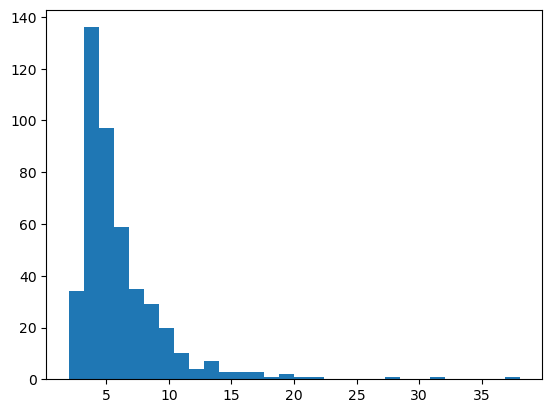

In [12]:
test = utils.pickle_load(SAVE_PATH / (SORTERS[1].name + ".pickle"))
hist = []
for unit in test:
    hist.append(np.mean(unit['spike_rmses']))
import matplotlib.pyplot as plt
plt.hist(hist, bins=30)
plt.show()